Load imports

In [1]:
import pandas as pd
import numpy as np
from models.gan import GAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime

Load dataset

In [2]:
df_pokemon= pd.read_csv("data/preprocessed_pokemon.csv")
df_pokemon.head()

,Unnamed: 0,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,1,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,2,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


Preprocessing

In [3]:
df_pokemon = df_pokemon.drop(columns=['Name', 'Unnamed: 0'], axis=1)
numerical_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
scaler = StandardScaler()
df_pokemon[numerical_cols] = scaler.fit_transform(df_pokemon[numerical_cols])
df_pokemon['Type 2'] = df_pokemon['Type 2'].fillna('None')
df_pokemon = pd.get_dummies(df_pokemon, columns=['Type 1', 'Type 2', 'Generation'])
bool_cols = df_pokemon.select_dtypes(include=['bool']).columns
df_pokemon[bool_cols] = df_pokemon[bool_cols].astype(int)
column_names = df_pokemon.columns
df_pokemon.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_)Normal,Type 1_Bug,Type 1_Dark,...,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6
0,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Train GAN model

In [4]:
noise = np.random.normal(0, 1, df_pokemon.shape) 
gan = GAN(data=df_pokemon, noise_dim=100, epochs=150, batch_size=32)
generator = gan.create_generator()
discriminator = gan.create_discriminator()
gan_model = gan.compile(generator=generator, discriminator=discriminator)
trained_generator, d_losses, g_losses = gan.train(generator, discriminator, gan_model)

c:\Users\l.huber2\Documents\FH\2. Semester\GAI\Pokemon\venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
>1, d_loss=0.720, g_loss=0.949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>2, d_loss=0.721, g_loss=0.944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>3, d_loss=0.711, g_loss=0.850
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
>4, d_loss=0.708, g_loss=0.814
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>5, d_loss=0.705, g_loss=0.777
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>6, d_loss=0.705, g_loss=0.726
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
>7, d_loss=0.709, g_loss=0.693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>8, d_loss=0.724, g_loss=0.649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>9, d_loss=0.738, g_loss=0.615
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>10, d_loss=0.755, g_loss=0.593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>11, d_loss=0.769, g_loss=0.576
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>12, d_loss=0.781, g_loss=0.556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>13, d_loss=0.790, g_loss=0.539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
>14, d_loss=0.799, g_loss=0.525
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

Get predicitions of GAN model

In [23]:
generate_num = 15
noise = np.random.normal(0, 1, (generate_num, 100))
predicted_data = trained_generator.predict(noise)
predicted_df = pd.DataFrame(predicted_data, columns=column_names)
predicted_df.head(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_)Normal,Type 1_Bug,Type 1_Dark,...,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6
0,-0.994801,0.999574,-0.998973,-0.997877,0.881911,-0.672528,-0.983241,-0.979610,-0.999642,-0.363010,...,0.999993,-0.956394,0.999159,1.000000,0.999945,0.985850,0.269593,-0.999568,0.999217,-0.999998
1,-0.987337,-0.511673,-0.899374,0.992736,0.963158,-0.874350,0.999822,0.014816,-0.536292,-0.999633,...,0.522205,0.926398,-0.990959,0.703687,0.999797,-0.159124,0.669592,0.998029,0.999063,-0.378248
2,-0.999997,-0.695452,-0.999518,-0.927155,-0.805584,-0.679402,0.990962,-0.752490,-0.902088,0.999766,...,0.980947,0.497128,0.188234,0.960649,0.999997,0.484393,-0.887931,0.401428,0.902696,-0.369534
3,1.000000,-1.000000,1.000000,0.973938,0.989474,-0.998231,1.000000,0.999999,0.999422,-0.999123,...,-0.955452,0.998914,-1.000000,-1.000000,-0.999650,-0.999985,0.567298,1.000000,-0.820922,1.000000
4,0.925061,-0.999994,-0.028546,-0.990002,-0.881795,-0.998273,0.996051,-0.211632,0.985453,-0.938396,...,0.915218,0.998774,-0.958542,0.993142,0.999002,-0.477062,0.999861,0.893625,0.892624,0.964868
5,-0.306222,0.999994,-0.907677,-0.603195,-0.999914,0.093923,-0.724376,-0.974234,0.904069,0.870819,...,-0.827142,0.528154,0.875290,-0.994054,0.999778,-0.998520,0.244718,-0.998060,0.970334,-0.247412
6,1.000000,-1.000000,1.000000,0.777661,0.987084,-0.999912,1.000000,1.000000,0.998176,-0.999609,...,0.997799,0.992194,-1.000000,-0.999990,-0.999999,-0.272769,0.982231,1.000000,0.697354,1.000000
7,-0.405423,-0.999954,0.977397,-0.396695,-0.995242,-0.999990,0.999933,-0.628715,0.998763,-0.922494,...,0.857241,0.964307,-0.869110,-0.962472,-0.955977,-0.999616,1.000000,0.994961,0.993609,0.999995
8,1.000000,-1.000000,0.992813,0.999999,0.999847,-1.000000,1.000000,0.999999,0.650176,-0.999952,...,0.845560,0.999995,-0.976230,0.956860,-0.999756,0.999999,0.999977,1.000000,0.999887,0.996891
9,-0.551439,-0.999994,-0.946284,0.854125,-0.996937,-0.839783,0.999473,0.045405,0.767707,0.983524,...,-0.979947,0.999888,-0.687926,0.530477,0.923961,0.990114,0.999884,0.997905,0.918438,0.992936


Transform prediction to human readable output

In [6]:
def make_binary_attributes_readable(attributes:list) -> pd.DataFrame:
    for attribute in attributes:
        columns = [col for col in predicted_df.columns if attribute in col]

        # Get the column with the highest value for each row among 'Type 1' columns
        max = predicted_df[columns].idxmax(axis=1)

        # Extract the type name from the column names (removing the 'Type 1_' prefix)
        predicted_df[attribute[:-1]] = max.str.replace(attribute, '')

        # Optionally, you can drop the old type columns if they are no longer needed
        predicted_df.drop(columns=columns, inplace=True)
        predicted_df.head()
    return predicted_df

In [24]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
make_readble_cols= ["Generation_", "Type 1_", "Type 2_",]
readable_df = make_binary_attributes_readable(make_readble_cols) 
readable_df['Legendary'] = readable_df['Legendary'] > 0.25 
readable_df[numerical_cols] = scaler.inverse_transform(readable_df[numerical_cols])
readable_df = readable_df.round(0)
readable_df['Total'] = readable_df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].sum(axis=1)
pd.DataFrame.to_csv(readable_df, path_or_buf=f'models/evaluation/data/GAN_generated_data{timestamp}csv')
readable_df.head(10)

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Generation,Type 1,Type 2,Total
0,44.0,111.0,43.0,40.0,96.0,49.0,False,1,Water,Water,383.0
1,44.0,62.0,46.0,105.0,99.0,43.0,True,1,Fire,Poison,399.0
2,44.0,56.0,43.0,43.0,49.0,49.0,True,1,Fighting,Dragon,284.0
3,95.0,47.0,105.0,105.0,99.0,39.0,True,6,Electric,Bug,490.0
4,93.0,47.0,73.0,40.0,47.0,39.0,True,3,Steel,Fire,339.0
5,61.0,111.0,46.0,53.0,44.0,71.0,False,1,Water,Flying,386.0
6,95.0,47.0,105.0,98.0,99.0,39.0,True,4,)Normal,Bug,483.0
7,59.0,47.0,104.0,60.0,44.0,39.0,True,3,Normal,Fighting,353.0
8,95.0,47.0,105.0,106.0,100.0,39.0,True,4,Grass,Fighting,492.0
9,55.0,47.0,44.0,101.0,44.0,44.0,True,3,Fighting,Rock,335.0


Evaluate GAN

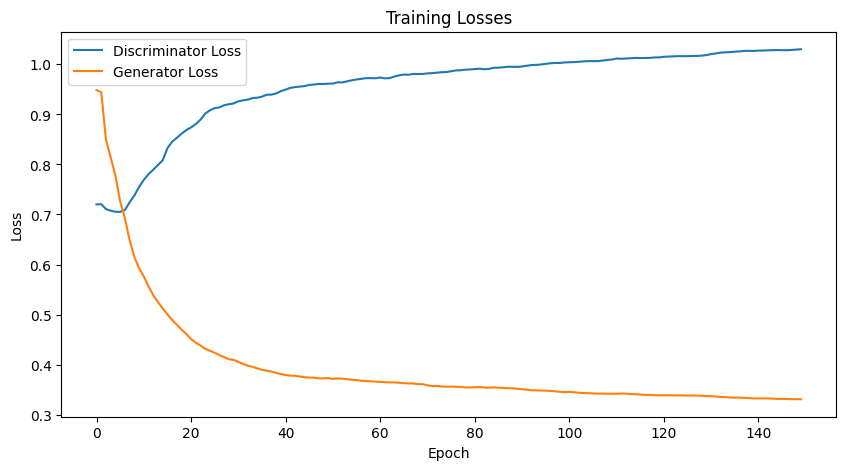

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'models/evaluation/plots/GAN_Training_Losses{timestamp}.png')
plt.show()

In [9]:
#TODO: Evaluare Model